In [38]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
all_photos = np.load('KnightPhotos.npy')

all_labels = np.load('KnightLabels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load('KnightVectors.npy')

all_degrees = np.load('KnightRotationDegrees.npy')
all_albedos = np.load('KnightAlbedos.npy')
all_normals = np.load('KnightNormals.npy')
all_masks = np.load('KnightMasks.npy')

(64, 256, 3)


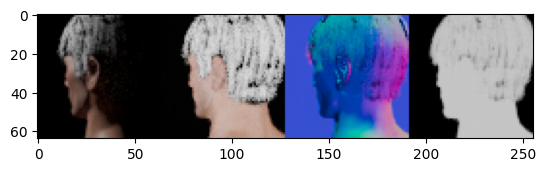

In [40]:
def ShowImageSeriesUpTo16(imageList): # input is normal LIST
    if len(imageList) > 64: 
        return
    while len(imageList) % 4 != 0:
        imageList.append(np.ones(imageList[0].shape))
    readyRows = list()
    for y in range(len(imageList) // 4):
        readyRows.append(np.concatenate((imageList[y * 4 +0],imageList[y * 4 +1],imageList[y * 4 +2],imageList[y * 4 +3]), axis = 1))

    final = np.concatenate(readyRows, axis = 0)
    return final
myArray = [all_photos[0], all_albedos[0], all_normals[0], all_masks[0]]
ExpandedImage = ShowImageSeriesUpTo16(myArray).astype('float32')
print(ExpandedImage.shape)
plt.imshow(ExpandedImage)

In [57]:
def ManualCheck(original_index):
    #print(all_photos.shape)
    inputt = all_photos[original_index].reshape(1, 64, 64, 3)
    prediction = model.predict(inputt)[0].round(3)
    origV = (all_vectors[original_index]).round(3)
    predV = (prediction).round(3)
    print("Prediction  : ", predV)
    print("Ground truth: ", origV)
    print("Diff ", origV - predV)
    print("Total Diff ", np.sum(origV - predV))
    
    print("orig L: ", np.linalg.norm(origV))
    print("pred L: ", np.linalg.norm(predV))
    plt.imshow(all_photos[original_index].astype("float32"))

In [ ]:
train_size = int(0.95 * len(all_vectors))

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_vectors))
dataset = dataset.shuffle(buffer_size=128, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

print(len(list(train_dataset)), len(list(test_dataset)))

In [ ]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear', input_shape=(64, 64, 3)),
  #tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(4, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(5, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(5, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(6, (5, 5), activation='linear'),
  tf.keras.layers.Conv2D(6, (5, 5), activation='linear'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(32, activation='linear'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(24, activation='linear'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(16, activation='linear'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(3)
])
model.compile(optimizer='adam',
              loss='mean_absolute_error', #mean_squared_error
              metrics=['mean_absolute_error'])             
model.summary()

In [ ]:
tf.keras.utils.set_random_seed(42)
model.fit(train_dataset, epochs=5)

In [ ]:
model.evaluate(test_dataset)

In [ ]:
ManualCheck(2500)

In [99]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((64, 64, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.compile(optimizer='adam',
              loss='mean_absolute_error', #mean_squared_error
              metrics=['mean_absolute_error'])
#discriminator.summary()

In [106]:
# Create the generator.
generator = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(4, (5,5), input_shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(5, (5,5)), tf.keras.layers.Conv2D(5, (5,5)),
        tf.keras.layers.Conv2D(6, (5,5)), tf.keras.layers.Conv2D(6, (5,5)),
        tf.keras.layers.Conv2D(7, (5,5)), tf.keras.layers.Conv2D(7, (5,5)),
        tf.keras.layers.Conv2D(8, (5,5)), tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(8*8*8),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(8*8*8),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        
        tf.keras.layers.Dense(16 * 16 * 6),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((16, 16, 6,)),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.compile(optimizer='adam',
              loss='mean_absolute_error', #mean_squared_error
              metrics=['mean_absolute_error'])        
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 60, 60, 4)         304       
                                                                 
 conv2d_54 (Conv2D)          (None, 56, 56, 5)         505       
                                                                 
 conv2d_55 (Conv2D)          (None, 52, 52, 5)         630       
                                                                 
 conv2d_56 (Conv2D)          (None, 48, 48, 6)         756       
                                                                 
 conv2d_57 (Conv2D)          (None, 44, 44, 6)         906       
                                                                 
 conv2d_58 (Conv2D)          (None, 40, 40, 7)         1057      
                                                                 
 conv2d_59 (Conv2D)          (None, 36, 36, 7)         12

71 8


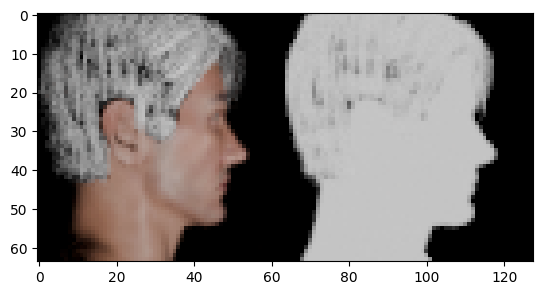

In [107]:
batch_size = 64
train_size = int(0.95 * len(all_labels))

dictDegrees = dict()
for i in range(len(all_degrees)):
    dictDegrees[all_degrees[i]] = all_masks[i]

answerList = list()
for i in range(len(all_photos)):
    answerList.append(dictDegrees[all_labels[i]])
answerList = np.array(answerList)

dataset = tf.data.Dataset.from_tensor_slices((all_photos, answerList))
dataset = dataset.shuffle(buffer_size=128, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(32)

print(len(list(train_dataset)), len(list(test_dataset)))
imtoshownum = 4100
imtoshow = np.concatenate( [all_photos[imtoshownum], answerList[imtoshownum]], axis=1).astype("float32")
plt.imshow(imtoshow)

In [110]:
num_epochs = 1
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
d_optimizer=keras.optimizers.Adam(learning_rate=0.0003)
g_optimizer=keras.optimizers.Adam(learning_rate=0.0003)
for epoch in range(num_epochs):
    print("start training epoch ", epoch)
    for batch_idx, (photos, normals) in enumerate(train_dataset):
        # PREDICTIONS
        generated_normals = generator(photos)
        # COMBINED

        combined_images = np.concatenate( [normals, generated_normals], axis=0 )
        # Assemble labels discriminating real from fake images.
        labels = np.concatenate( [np.ones((batch_size, 1)), np.zeros((batch_size, 1))], axis=0)
        
        # Train the DISCRIMINATOR.
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images)
            d_loss = loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(
            zip(grads, discriminator.trainable_weights)
        )
        
        



start training epoch  0
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) (64, 64, 64, 3)
(64, 64, 64, 3) 

ValueError: `logits` and `labels` must have the same shape, received ((112, 1) vs (128, 1)).

In [95]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # INPUTS
        # npp = tfds.as_numpy(data)
        # real_images, normal_images = list(), list()
        # for ex in npp:
        #     real_images.append(ex[0])
        #     normal_images.append(ex[1])
        # print(len(real_images), len(normal_images))
        x, y = data
        #print(x)
        for ex in x:
            print(ex)

        # PREDICTIONS
        generated_normals = self.generator(real_images)

        #np_real_images = np.array(real_images)

        # COMBINED
        combined_images = ops.concatenate( [normal_images, generated_normals], axis=0 )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate( [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0)

        # Train the DISCRIMINATOR.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(real_images)
            predictions = self.discriminator(fake_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator
# )
# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
# )

In [81]:
model.evaluate(test_dataset)

8/8 [==============================] - 0s 4ms/step - loss: 0.1126 - mean_squared_error: 0.1126


[0.11262122541666031, 0.11262122541666031]

1/1 [==============================] - 0s 89ms/step


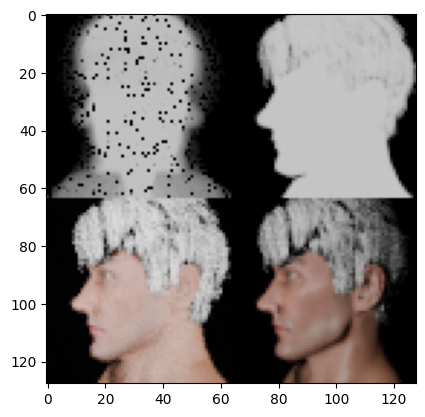

In [82]:
imagetoCheck = 1000
result = model.predict(all_photos[imagetoCheck].reshape(1, 64, 64, 3))

plt.imshow(
    np.concatenate( (
    np.concatenate( (np.concatenate([result[0], result[0],result[0]], axis=2 ), all_masks[imagetoCheck // 191]), axis=1),
    np.concatenate( (all_albedos[imagetoCheck // 191], all_photos[imagetoCheck]), axis=1)    
    ), axis = 0 )
          )

In [61]:
result = model.predict(np.array([all_photos[0], all_photos[1000], all_photos[2000], all_photos[4000]]))
plt.imshow(
    np.concatenate( (
    np.concatenate( (result[0], all_masks[   0 // 191], result[1], all_masks[ 1000 // 191]), axis=1),
    np.concatenate( (result[2], all_masks[2000 // 191], result[3], all_masks[4000 // 191]), axis=1)    
    ), axis = 0 ) )

1/1 [==============================] - 0s 20ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 3